In [2]:
!pip install tensorflow-text
!pip install tf-models-official

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tftext
from official.nlp import optimization # Use for adamW
from official.nlp.bert import tokenization
from official.nlp.bert import bert_models
import tensorflow_hub as hub

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import os
import re

In [5]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1", trainable=True)

# Lets load our dataset using tensorflow datasets
- We will be using the sentiment140
- Contains tweets with the following categories:
- You can read up here: https://www.tensorflow.org/datasets/catalog/sentiment140

In [6]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'imdb_reviews', with_info=True, as_supervised=True,
    split=['train', 'test[50:]', 'test[:50]']
)

In [7]:
# Some eda to understand a bit
for text, label in train_ds.shuffle(1024).take(10):
  print(text.numpy(), label.numpy())

b"This film was very well advertised. I am an avid movie goer and have seen previews for this movie for months. While I was somewhat skeptical of how funny this movie would actually be, my friends thought it was going to be great and hyped me up about it. Then I went and saw it, I was sunk down in my seat almost asleep until I remembered that I had paid for this movie. I made myself laugh at most of the stuff in the movie just so i wouldnt feel bad and destroy the good mood I was in, plus I wanted to get my monies worth out of the movie! I always go into a movie with an open mind, not trying to go into them with too many expectations, but this movie was not that funny. Now it wasnt the worst movie I've ever seen, but it is definitely worth waiting for HBO. If you havent seen many previews for the movie or you like very slow and corny comedies you may enjoy it, but for true comedy fans Id say pass. Maybe even check out The Kings of Comedy again. Something told me to go see Meet the Pare

In [8]:
train_df = tfds.as_dataframe(train_ds, ds_info)
valid_df = tfds.as_dataframe(valid_ds, ds_info)

In [9]:
train_df.head()

,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...
3,1,b'This is the kind of film for a snowy Sunday ...
4,1,"b'As others have mentioned, all the women that..."


In [10]:
train_df['length'] = train_df['text'].apply(lambda x: len(x))

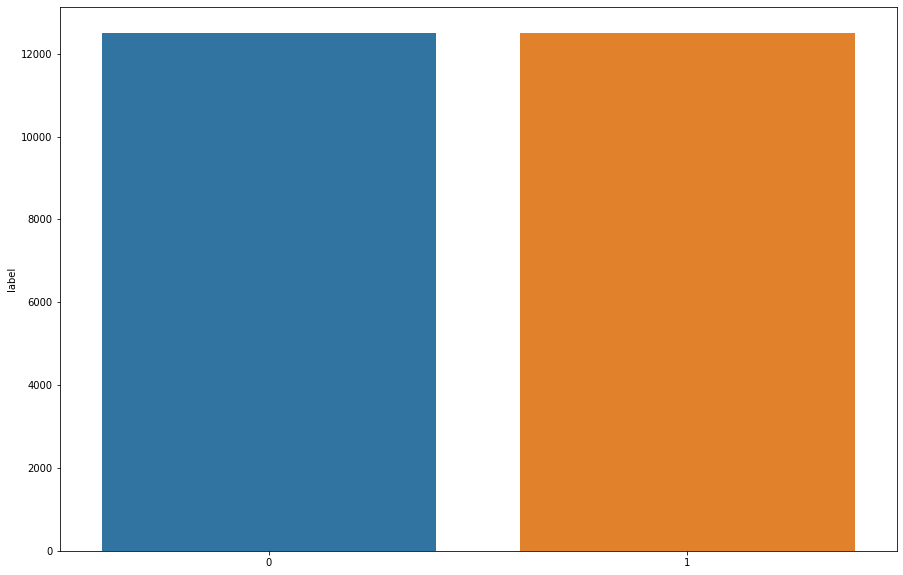

In [11]:
plt.figure(figsize=(15, 10))
count = train_df['label'].value_counts()
sns.barplot(x=count.index, y=count)

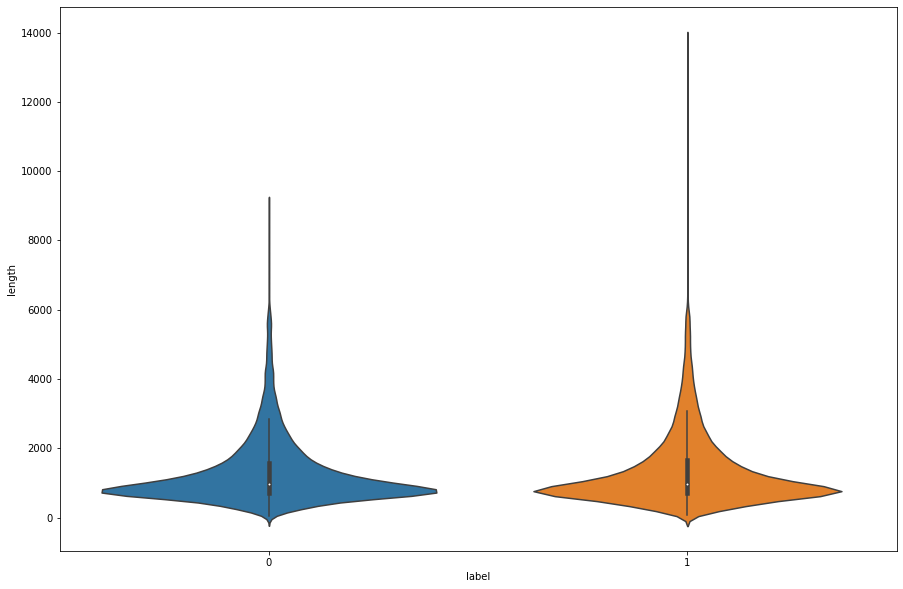

In [12]:
plt.figure(figsize=(15, 10))
sns.violinplot(data=train_df, y='length', x='label')

# Load tokenizer
- We will load our tokenizer with the gs folder we have above
- We will create tokens similar to how huggingfaces does it

In [13]:
def bert_encode(text, tokenizer, max_len=512):
  tokenized_text = tokenizer.tokenize(text)
  input_seq = ["[CLS]"] + tokenized_text[:max_len-2] + ["[SEP]"]
  pad_len =  max_len - len(input_seq)
  tokens = tokenizer.convert_tokens_to_ids(input_seq)
  tokens += [0] * pad_len
  pad_masks = [1] * len(input_seq) + [0] * pad_len
  segment_ids = [0] * max_len  

  return tokens, pad_masks, segment_ids

def preproc(text):
  text = re.sub('[^0-9a-zA-Z]+', ' ', text)
  return text.lower().strip()

In [14]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = tokenization.FullTokenizer(
    vocab_file, do_lower_case=do_lower_case
)

In [15]:
train_df = train_df.dropna(subset=['text'])
valid_df = valid_df.dropna(subset=['text'])

In [16]:
train_text = train_df['text'].apply(lambda x: preproc(x.decode('utf-8'))).tolist()
train_labels = train_df['label'].tolist()

valid_text = valid_df['text'].apply(lambda x: preproc(x.decode('utf-8'))).tolist()
valid_labels = valid_df['label'].tolist()

In [17]:
train_tokens = []
train_pad_mask = []
train_segment_ids = []

for text in train_text:
  tokens, pad_masks, segment_ids = bert_encode(text, tokenizer, max_len=100)
  train_tokens.append(tokens)
  train_pad_mask.append(pad_masks)
  train_segment_ids.append(segment_ids)

valid_tokens = []
valid_pad_mask = []
valid_segment_ids = []

for text in valid_text:
  tokens, pad_masks, segment_ids = bert_encode(text, tokenizer, max_len=100)
  valid_tokens.append(tokens)
  valid_pad_mask.append(pad_masks)
  valid_segment_ids.append(segment_ids)

In [18]:
norm_train_ds = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_tokens,
    'pad_tokens': train_pad_mask,
    'segment_ids': train_segment_ids
}, train_labels))

norm_test_ds = tf.data.Dataset.from_tensor_slices(({
    'input_ids': valid_tokens,
    'pad_tokens': valid_pad_mask,
    'segment_ids': valid_segment_ids
}, valid_labels))

In [19]:
@tf.function
def norm_labels(data, labels):
  return data, tf.one_hot(labels, 2)

norm_train_ds = norm_train_ds.shuffle(len(norm_train_ds)).map(norm_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16).prefetch(tf.data.experimental.AUTOTUNE)
norm_test_ds = norm_test_ds.map(norm_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16).prefetch(tf.data.experimental.AUTOTUNE)

# Lets build our bert model
- This will be a multi input model of 3 things
  - input_ids: the tokenized words
  - the pad tokens: to tell which tokens are padded
  - segment_ids: which are broken down to different sentences
- We will load it via tf-keras hub layer

In [20]:
def build_model(bert_layer, max_len=512):
  input_word_ids = tf.keras.layers.Input(shape=(max_len), dtype=tf.int32, name='input_ids')
  input_mask = tf.keras.layers.Input(shape=(max_len), dtype=tf.int32, name='pad_tokens')
  segment_ids = tf.keras.layers.Input(shape=(max_len), dtype=tf.int32, name='segment_ids')

  _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
  clf_output = sequence_output[:, 0,:]
  fc1 = tf.keras.layers.Dense(256, activation='gelu')(clf_output)
  output = tf.keras.layers.Dense(2, activation='softmax')(fc1)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=output)

  return model

In [21]:
model = build_model(bert_layer, max_len=100)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
pad_tokens (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_ids[0][0]                  
                                                                 pad_tokens[0][0]             

In [23]:
adamw = optimization.create_optimizer(
    2e-5, num_train_steps=1200, num_warmup_steps=100
)

In [24]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=adamw,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Train model

In [25]:
history = model.fit(norm_train_ds, epochs=2, validation_data=norm_test_ds)

Epoch 1/2
1563/1563 [==============================] - 2315s 1s/step - loss: 0.3106 - accuracy: 0.8634 - precision: 0.8634 - recall: 0.8634 - auc: 0.9376 - val_loss: 0.2628 - val_accuracy: 0.8907 - val_precision: 0.8907 - val_recall: 0.8907 - val_auc: 0.9530
Epoch 2/2
1563/1563 [==============================] - 2285s 1s/step - loss: 0.1737 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9773 - val_loss: 0.2628 - val_accuracy: 0.8907 - val_precision: 0.8907 - val_recall: 0.8907 - val_auc: 0.9530


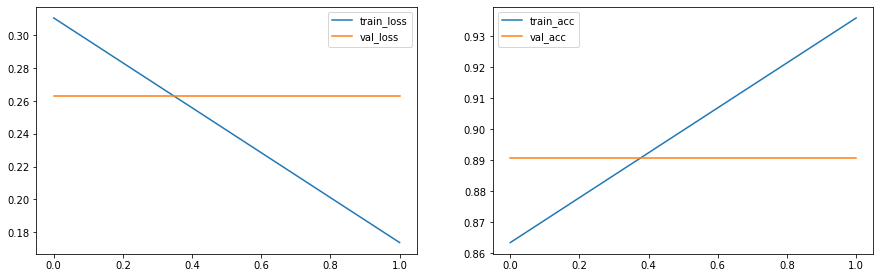

In [29]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(222)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

# Evaluation

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

In [30]:
model.evaluate(norm_test_ds)

1560/1560 [==============================] - 547s 350ms/step - loss: 0.2628 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9530


[0.2627659738063812,
 0.8907414674758911,
 0.8907414674758911,
 0.8907414674758911,
 0.9530277252197266]

In [31]:
y_pred = model.predict(norm_test_ds)

In [35]:
print(classification_report(valid_labels, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12474
           1       0.89      0.89      0.89     12476

    accuracy                           0.89     24950
   macro avg       0.89      0.89      0.89     24950
weighted avg       0.89      0.89      0.89     24950



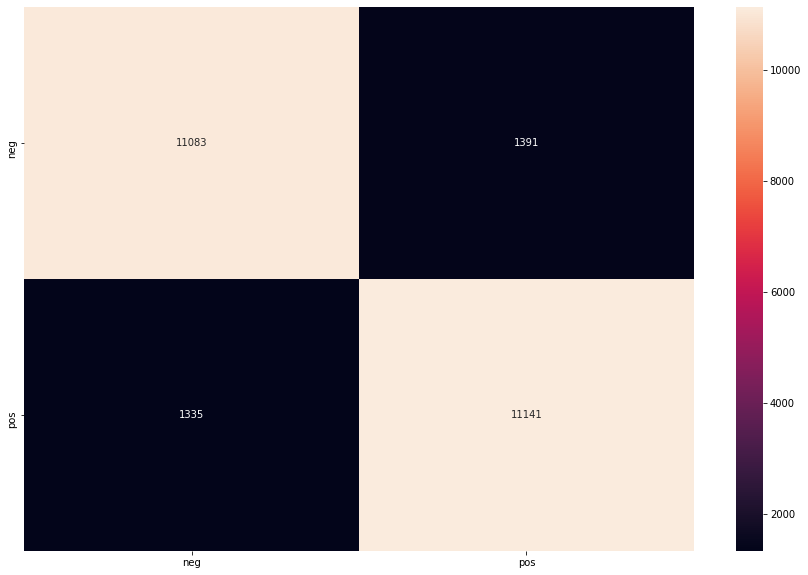

In [38]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(valid_labels, y_pred.argmax(axis=1)), fmt='3', annot=True, xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

In [43]:
print('MCC: {}%'.format(round(matthews_corrcoef(valid_labels, y_pred.argmax(axis=1)) * 100, 2)))

MCC: 78.15%
